# Fake News Capstone Project Data Preparation

Dataset downloaded from Fake News Corpus - https://github.com/several27/FakeNewsCorpus/releases/tag/v1.0

# Problem Statement

Due to the explosion of fake news and the fact that fake news reaches more audience than real/genuine news. It is very important that there is a way to quickly identify which news is fake or real so that they can be removed immediately in order to reduce the number of people it reach. We should be able to use machine learning algorithms to study word patterns in fake and real news to be able to distinguish which news is fake or real

# Hypothesis

**Ho (null hypothesis):**
___
There is no distinguishable difference between the word patterns of fake news and real news. I.e. The word patterns found in fake news is equal to the word patterns found in real news.

**Ha (alternative hypothesis):**
___
There is a distinguishable difference between the word patterns of fake news when compared with real news. I.e. machine learning classifiers can be used as a tool to assist in detecting and filtering out the word patterns of fake news. 


In [1]:
!pip install s3fs 

  Using cached botocore-1.19.52-py2.py3-none-any.whl (7.2 MB)
ERROR: boto3 1.17.47 has requirement botocore<1.21.0,>=1.20.47, but you'll have botocore 1.19.52 which is incompatible.
ERROR: awscli 1.19.47 has requirement botocore==1.20.47, but you'll have botocore 1.19.52 which is incompatible.
  Attempting uninstall: botocore
    Found existing installation: botocore 1.20.47
    Uninstalling botocore-1.20.47:
      Successfully uninstalled botocore-1.20.47


In [2]:
#import libraries and perform required configuration setup
import s3fs
import pandas as pd
import sys
import csv
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.autonotebook import tqdm
tqdm.pandas(desc='progress', leave=False)
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='darkgrid',palette='tab10',rc={'figure.figsize':(9,6),'figure.dpi':100})


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Setting a  random seed 

In [3]:
seed = 500

### CSV field limit 
**While trying to read the dataset using pandas, there was a `csv.Error` complaining about field larger than field limit (131072)**

In [4]:
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [5]:
#check the new field size limit
csv.field_size_limit()

9223372036854775807

## Ingest the Fake News Corpus Using chunk method

Downloaded data from Fake News Corpus - https://github.com/several27/FakeNewsCorpus/releases/tag/v1.0



In [6]:
# path to the csv file
csv_file_path = 's3://osanusi-auto/news_cleaned_2018_02_13.csv'

In [7]:
#chunksize for reading the dataset
chunksize = 500000 # 500 thousand rows at one go.

In [8]:
# function to read dataset into pandas dataframe
def read_data(path, chunksize):
    df_chunk=pd.read_csv(path, sep=',', lineterminator='\n' , chunksize=chunksize)
    chunk_list=[chunk for chunk in df_chunk]
    df =pd.concat(chunk_list)
    return df

In [9]:
%%time
df = read_data(csv_file_path, chunksize)

CPU times: user 5min 37s, sys: 1min 28s, total: 7min 5s
Wall time: 20min 52s


In [10]:
# See memory usage
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8528961 entries, 0 to 8528960
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        object 
 1   id                object 
 2   domain            object 
 3   type              object 
 4   url               object 
 5   content           object 
 6   scraped_at        object 
 7   inserted_at       object 
 8   updated_at        object 
 9   title             object 
 10  authors           object 
 11  keywords          float64
 12  meta_keywords     object 
 13  meta_description  object 
 14  tags              object 
 15  summary           float64
 16  source            object 
dtypes: float64(2), object(15)
memory usage: 50.9 GB


The data contains 17 columns and about 9 million rows.     From the  original repo `README`, the columns `type` and `tags` are the same because they represent the same classification of the content

## Examining the dataset

In [11]:
# Some few rows at the begining of the dataframe
df.head(3)

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
0,0,2,express.co.uk,rumor,https://www.express.co.uk/news/science/738402/...,"Life is an illusion, at least on a quantum lev...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Is life an ILLUSION? Researchers prove 'realit...,Sean Martin,NaN,[''],THE UNIVERSE ceases to exist when we are not l...,NaN,NaN,NaN
1,1,6,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,"Unfortunately, he hasn’t yet attacked her for ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN
2,2,7,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,The Los Angeles Police Department has been den...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN


In [12]:
df.shape
print('The dataframe contains:', df.shape[0] ,'rows', 'and', df.shape[1], 'columns')

The dataframe contains: 8528961 rows and 17 columns


## Checking the missing values 

In [13]:
def missing_value(df):
    """" Function to calculate the number and percent of missing values in a dataframe"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_value = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    return missing_value

In [14]:
# check and print out the missing values in the data
missing_value(df)

,Total,Percent
keywords,8528961,100.000000
summary,8528961,100.000000
source,6648367,77.950491
tags,6560414,76.919264
meta_description,4481827,52.548335
authors,3791519,44.454641
type,403216,4.727610
meta_keywords,337923,3.962065
title,73234,0.858651
updated_at,13,0.000152


## Drop all columns that have missing values rate higher than 40%

In [15]:
def drop_missing_cols (df, threshold=0.4):
	""" Drop missing values for columns which have missing values
	rate higher than threshold( default=70%) """
	df = df[df.columns[df.isnull().mean() < threshold]]
	return df

In [16]:
%%time
df = drop_missing_cols(df)

CPU times: user 6.02 s, sys: 363 ms, total: 6.38 s
Wall time: 6.36 s


## Dropping other unnecessay columns

In [17]:
# list of columns to drop from the datasets
cols_to_drop = ['id','Unnamed: 0', 'url', 'meta_keywords','scraped_at','updated_at', 'inserted_at']

In [18]:
%%time
# drop the columns and check the memory usage
df.drop(cols_to_drop, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8528961 entries, 0 to 8528960
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   domain   object
 1   type     object
 2   content  object
 3   title    object
dtypes: object(4)
memory usage: 260.3+ MB
CPU times: user 825 ms, sys: 132 ms, total: 957 ms
Wall time: 953 ms


In [19]:
# The first 3 rows of the new dataframe
df.head(3)

,domain,type,content,title
0,express.co.uk,rumor,"Life is an illusion, at least on a quantum lev...",Is life an ILLUSION? Researchers prove 'realit...
1,barenakedislam.com,hate,"Unfortunately, he hasn’t yet attacked her for ...",Donald Trump
2,barenakedislam.com,hate,The Los Angeles Police Department has been den...,Donald Trump


In [20]:
# Checking for null values
missing_value(df)

,Total,Percent
type,403216,4.727610
title,73234,0.858651
content,7,0.000082
domain,3,0.000035


In [21]:
# dropping remaining missing values
df = df.dropna().reset_index(drop=True)
missing_value(df)

,Total,Percent
title,0,0.0
content,0,0.0
type,0,0.0
domain,0,0.0


## Checking the number of unique values in the type column

In [22]:
df['type'].value_counts(dropna=False, ascending=False)

reliable      1913218
political     1657091
bias          1138658
fake           894737
conspiracy     759156
rumor          481159
unknown        371433
unreliable     298583
clickbait      231949
junksci        117464
satire         112669
hate            76495
Name: type, dtype: int64

### From the metadata provided on the Fake News Corpus repo. 

| **Tag**    | **Description**                                              |
| ---------- | ------------------------------------------------------------ |
| fake       | Sources that entirely fabricate information, disseminate deceptive  content, or grossly distort actual news reports |
| satire     | Sources that use humor, irony, exaggeration, ridicule, and false  information to comment on current events. |
| bias       | Sources that come from a particular point of view and may rely on  propaganda, decontextualized information, and opinions distorted as facts. |
| conspiracy | Sources that are well-known promoters of kooky conspiracy theories. |
| state      | Sources in repressive states operating under government sanction. |
| junksci    | Sources that promote pseudoscience, metaphysics, naturalistic  fallacies, and other scientifically dubious claims. |
| hate       | Sources that actively promote racism, misogyny, homophobia, and  other forms of discrimination. |
| clickbait  | Sources that provide generally credible content, but use  exaggerated, misleading, or questionable headlines, social media  descriptions, and/or images. |
| unreliable | Sources that may be reliable but whose contents require further  verification. |
| political  | Sources that provide generally verifiable information in support of  certain points of view or political orientations. |
| reliable   | Sources that circulate news and information in a manner consistent  with traditional and ethical practices in journalism (Remember: even credible  sources sometimes rely on clickbait-style headlines or occasionally make  mistakes. No news organization is perfect, which is why a healthy news diet  consists of multiple sources of information). |

1. `rumor` is not among the classes specified in the `type` or `tags` column
2. The two classes `rumor` and `unknown` can be dropped 
3. All the other unneeded classes were also dropped

### Dropping all the unneeded classes 

In [23]:
# list of classes in the type column that need to be kept
classes_to_keep = ['fake','reliable','bias','political','clickbait','junksci','satire']


In [24]:
df = df[df['type'].isin(classes_to_keep)].reset_index(drop=True)

In [25]:
df['type'].value_counts(dropna=False, ascending=False)

reliable     1913218
political    1657091
bias         1138658
fake          894737
clickbait     231949
junksci       117464
satire        112669
Name: type, dtype: int64

## Recode the classes

In [26]:
# Recode the classes into binary classes
fakenews = ['bias', 'fake', 'clickbait', 'junksci', 'satire']

def recode_column(new):
    if new in fakenews:
        return 0 # fake
    else:
        return 1 # real

In [27]:
%%time
df['type'] = df['type'].apply(recode_column)
df.head(3)

CPU times: user 2.42 s, sys: 164 ms, total: 2.58 s
Wall time: 2.58 s


,domain,type,content,title
0,bipartisanreport.com,0,The website from which you got to this page is...,Email Protection
1,theshovel.com.au,0,"For as long as he can remember, Malcolm Turnbu...",malcolm turnbull satire – The Shovel
2,theshovel.com.au,0,"For as long as he can remember, Malcolm Turnbu...",malcolm turnbull jokes – The Shovel


In [28]:
df.shape
print('The dataframe contains:', df.shape[0] ,'rows', 'and', df.shape[1], 'columns')

The dataframe contains: 6065786 rows and 4 columns


## Rename  binary class in type column to fake and real

In [29]:
#Labeling the class
class_labels = ['fake','real']

#replace the class
df['type'] = df['type'].replace([0,1], class_labels)

# check the column values
df['type'].value_counts(dropna=False, ascending=False)

real    3570309
fake    2495477
Name: type, dtype: int64

In [30]:
#Check the remaining missing values
missing_value(df)

,Total,Percent
title,0,0.0
content,0,0.0
type,0,0.0
domain,0,0.0


## Visualize the type column

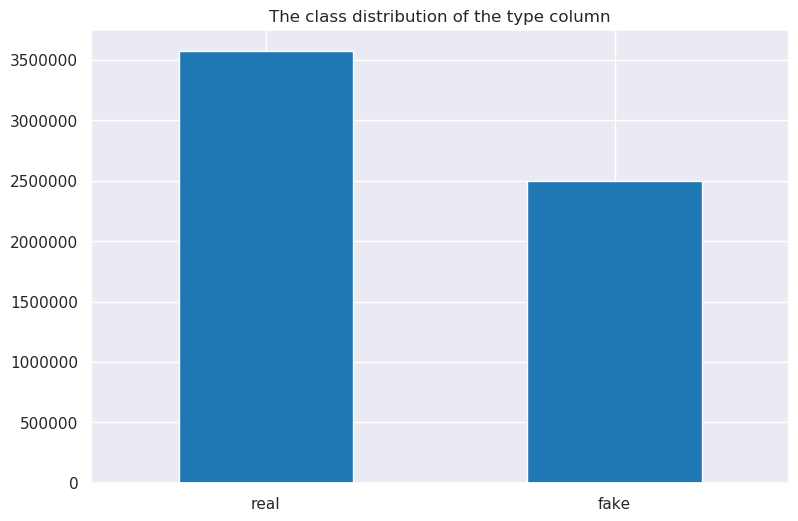

In [31]:
df['type'].value_counts(dropna=False, ascending=False).plot.bar(rot=0, title='The class distribution of the type column');

There is a class imbalance which will create a bias in the model training. The majority class need to be downsampled.

In [32]:
def balanced_classes(df):
    #Separate majority and minority classes
    majority = df[df.type=='real']
    minority = df[df.type=='fake']

    # Downsample majority class
    majority_downsampled = resample(majority, 
                                    replace=False, # sample without replacement
                                    n_samples=len(minority), # to match minority class
                                    random_state=seed) # reproducible results

    # Combine minority class with downsampled majority class
    df = pd.concat([majority_downsampled, minority])
    return df

In [33]:
%%time
df = balanced_classes(df)

CPU times: user 3.73 s, sys: 236 ms, total: 3.96 s
Wall time: 3.96 s


In [34]:
# See deep memory usage
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4990954 entries, 4318408 to 4185195
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   domain   object
 1   type     object
 2   content  object
 3   title    object
dtypes: object(4)
memory usage: 25.9 GB


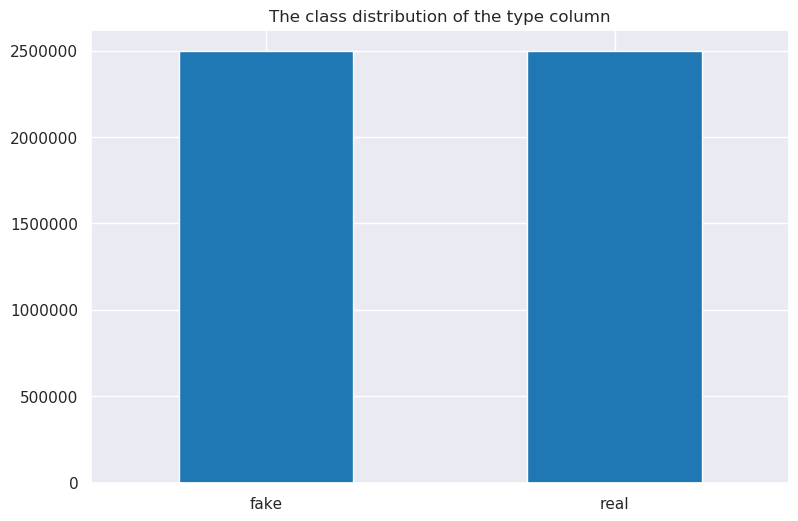

In [35]:
df['type'].value_counts(dropna=False, ascending=False).plot.bar(rot=0, title='The class distribution of the type column');

In [36]:
df.groupby('type')['domain'].nunique().reset_index()

,type,domain
0,fake,323
1,real,134


### Sample just 2 million instances of Dataframe

In [40]:
df = resample(df, n_samples=2_000_000, replace=False, random_state=seed)

In [42]:
df['type'].value_counts()

real    1000604
fake     999396
Name: type, dtype: int64

#### Downsample Majority once again

CPU times: user 1.24 s, sys: 43.8 ms, total: 1.29 s
Wall time: 1.28 s


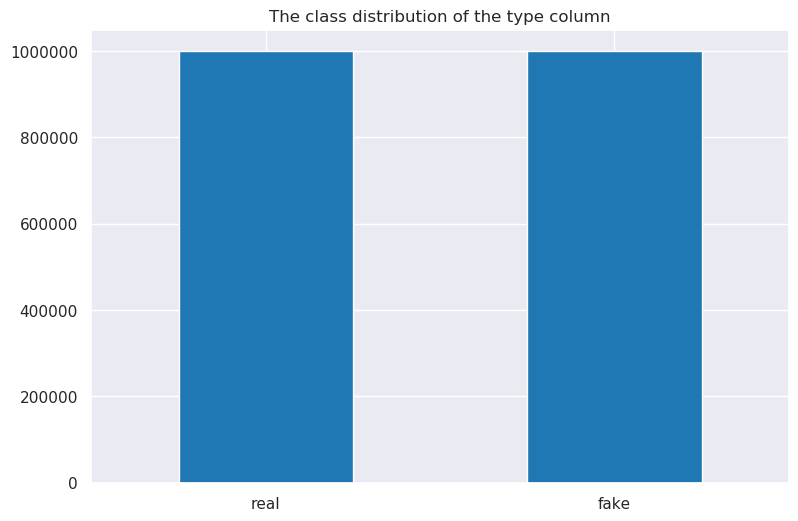

In [43]:
%%time
df = balanced_classes(df)
df['type'].value_counts(dropna=False, ascending=False).plot.bar(rot=0, title='The class distribution of the type column');

In [44]:
# See deep memory usage of the subsetted 2 miilion rows
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998792 entries, 3264082 to 3837311
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   domain   object
 1   type     object
 2   content  object
 3   title    object
dtypes: object(4)
memory usage: 10.4 GB


## Rename the target column

In [46]:
df = df.rename({'type': 'label'}, axis=1)  

## Rearranged the order of the columns

In [47]:
df = df[['domain','title','content','label']]
df.head(3)

,domain,title,content,label
3264082,dailykos.com,More and more British election talk,Because it's the big story of the night.\n\nUp...,real
3107180,christianpost.com,Brian Williams and the Tyranny of Ego,"Expand | Collapse Not available David French, ...",real
2282813,nakedcapitalism.com,Comments on: How American Corporations Transfo...,The Bible has an interesting (no pun intended)...,real


## Saving the dataframe to csv

In [48]:
file_path = 's3://osanusi-auto/fakenews2mil.csv'

In [49]:
df.to_csv(file_path, sep=',',index=False)